In [6]:
## Add imports here
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = 128

def initialise_projections(embed_dim, num_heads, head_dim):
    """
    create projections for Q, K, V.
    """
    print("doing initilaisze projectionss")
    W_q = nn.Linear(embed_dim, num_heads * head_dim)
    W_k = nn.Linear(embed_dim, num_heads * head_dim)
    W_v = nn.Linear(embed_dim, num_heads * head_dim)
    return W_q, W_k, W_v

def pairwise_similarities(q,k):
    """
    Compute dot product attention.
    """
    print("doing pairwise simi")
    k_transposed = k.transpose(-2, -1)

    # Compute QK^T using batch matrix multiplication
    attention_scores = torch.matmul(q, k_transposed)
    return attention_scores

def attention_scaled(attention_scores, head_dim):
    """
    Scale the raw attention scores.
    """
    print("scaling")
    scaling_factor = math.sqrt(head_dim)
    scaled_attention_scores = attention_scores / scaling_factor
    return scaled_attention_scores


def attention_softmax(attention_scores, mask = None):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    if mask is not None:
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
    attention_probs = F.softmax(attention_scores, dim=-1)
    return attention_probs

def compute_outputs(attention_weights, values):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    weighted_sum = torch.matmul(attention_weights, values)
    return weighted_sum


def make_causal_mask(seq_len):
    """
    Create a mask matrix that masks future context for the attention.
    """
    # Create a lower triangular matrix with ones on the diagonal and below
    mask = torch.tril(torch.ones(seq_len, seq_len)).type(torch.bool)

    return mask


def apply_causal_mask(attention_scores, causal_mask):
    """
    Apply mask to attention.
    """
    masked_attention_scores = attention_scores.masked_fill(causal_mask == 0, -1e9)

    return masked_attention_scores

def split_heads(input_tensor, num_heads, head_dim):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_len, embed_dim = input_tensor.size()
    reshaped_tensor = input_tensor.reshape(batch_size, seq_len, num_heads, head_dim)

    # Permute the dimensions to move the head dimension before the sequence length dimension
    output_tensor = reshaped_tensor.permute(0, 2, 1, 3)

    return output_tensor

def merge_heads(input_tensor, num_heads, head_dim):
    """
    Reversing splitting action of function split_heads().
    """
     # Permute the dimensions to move the head dimension back to its original position
    permuted_tensor = input_tensor.permute(0, 2, 1, 3)

    # Reshape the tensor to combine the heads
    batch_size, seq_len, _, _ = permuted_tensor.size()
    merged_tensor = permuted_tensor.reshape(batch_size, seq_len, num_heads * head_dim)

    return merged_tensor

def self_attention(x, W_q, W_k, W_v, num_heads, head_dim, causal_mask=None):
    """
    Self-attention block.
    """
     # 1) Project Q, K, V
    q = W_q(x)
    k = W_k(x)
    v = W_v(x)

    # 2) Split heads
    q, k, v = split_heads_qkv(q, k, v, num_heads, head_dim)

    # 3) Pairwise similarity and scaling
    scores = pairwise_similarities(q, k)
    scores = attention_scaled(scores, head_dim)

    # 4) Optional causal masking
    if causal_mask is not None:
        # Expand mask for multi-head shape: (batch=1, heads, seq_len, seq_len)
        scores = scores.masked_fill(causal_mask.unsqueeze(0).unsqueeze(1) == 0, float('-inf'))

    # 5) Softmax and weighted sum
    attn_probs = attention_softmax(scores)
    out = compute_outputs(attn_probs, v)

    # 6) Merge heads
    out = merge_heads(out, num_heads, head_dim)
    return out

def split_heads_qkv(q, k, v, num_heads, head_dim):
    """
    Split Q, K, V across multiple heads.
    """
    q = split_heads(q, num_heads, head_dim)
    k = split_heads(k, num_heads, head_dim)
    v = split_heads(v, num_heads, head_dim)
    return q, k, v

def load_and_preprocess_data():
    with open("/content/shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("/content/shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()
    with open("/content/shakespear_test.txt", "r") as f:
        lines_test = f.readlines()

    tokens_train = [line.split() for line in lines_train]

    # Utility function to flatten tokens
    def flat(tokens):
        ## Your code here
        return [tok for line in tokens for tok in line]

    token_counts = Counter(flat(tokens_train))

    ## Create tokenizer
    special_tokens = ["<PAD>", "<START>", "<STOP>", "<UNK>"]
    tokenizer = {st: i for i, st in enumerate(special_tokens)}
    for token, _ in token_counts.most_common():
        if token not in tokenizer:
            tokenizer[token] = len(tokenizer)

    ## Create inverse tokenizer for decoding
    tokenizer_inv = {v: k for k, v in tokenizer.items()}

    ## Prepare datasets
    data_train = [l.strip() for l in lines_train]
    data_val = [l.strip() for l in lines_dev]

    ## Create input-output pairs
    train_dataset = []
    val_dataset = []
    for line in data_train:
        # Convert to IDs; you might add padding or <START>/<STOP> as needed
        token_ids = [tokenizer.get(tok, tokenizer["<PAD>"]) for tok in line.split()]
        if len(token_ids) > 1:
            # Input is all tokens except the last, Output is all tokens except the first
            inp, out = token_ids[:-1], token_ids[1:]
            train_dataset.append((inp, out))


    for line in data_val:
        token_ids = [tokenizer.get(tok, tokenizer["<PAD>"]) for tok in line.split()]
        if len(token_ids) > 1:
            inp, out = token_ids[:-1], token_ids[1:]
            val_dataset.append((inp, out))

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    padded = tokens[:max_len]
    padded += [pad_id] * max(0, max_len - len(padded))
    return padded

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    words = sentence.split()
    token_ids = [tokenizer.get(w, tokenizer["<PAD>"]) for w in words]
    if include_stop and "<STOP>" in tokenizer:
        token_ids.append(tokenizer["<STOP>"])

    if pad_to_len is not None:
        token_ids = pad_to_length(token_ids, pad_to_len, tokenizer["<PAD>"])

    return token_ids


def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    words = []
    for t in tokens:
        if omit_pad and tokenizer_inv[t] == "<PAD>":
            continue
        if end_at_stop and tokenizer_inv[t] == "<STOP>":
            break
        words.append(tokenizer_inv[t])
    return " ".join(words)

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=0.6):
    """
    Generate a fixed number of tokens using the trained model.
    """
    ## Tokenize the context
    context_ids = tokenize(context, pad_to_len=None, tokenizer=tokenizer, include_stop=False)
    x = torch.tensor(context_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            ## Get predictions
            logits, _ = model(x)  # Model should return logits [batch, seq_len, vocab_size]

            ## Focus on the last token's predictions
            last_token_logits = logits[:, -1, :] / temperature

            ## Apply softmax to get probabilities
            probs = F.softmax(last_token_logits, dim=-1)

            ## Sample from the distribution
            next_token_id = torch.multinomial(probs, 1)

            ## Append to the context
            x = torch.cat([x, next_token_id], dim=1)

            ## Stop if we generated a STOP token
            if next_token_id.item() == tokenizer["<STOP>"]:
                break

    ## Convert back to text
    return decode(x[0].tolist(), tokenizer_inv)

In [ ]:
## Define the Transformer model
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=8, ff_dim=256, num_layers=4, max_len=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)

        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.fc_out.weight, mean=0.0, std=0.02)
        nn.init.constant_(self.fc_out.bias, 0)
        # Initialize positional embeddings
        nn.init.normal_(self.pos_embed, mean=0.0, std=0.02)

    def forward(self, x, mask=None):
        bsz, seq_len = x.shape
        # Token + positional embeddings
        pos_embed = self.pos_embed[:, :min(seq_len, self.pos_embed.shape[1]), :]
        if seq_len > self.pos_embed.shape[1]:
            # Pad or truncate positional embeddings if necessary
            diff = seq_len - self.pos_embed.shape[1]
            padding = torch.zeros(1, diff, self.pos_embed.shape[2], device=x.device) # Create padding tensor
            pos_embed = torch.cat([pos_embed, padding], dim=1) # Pad pos_embed to match seq_len

        x = self.embed(x) + pos_embed

        # Create causal mask if none provided
        if mask is None:
            mask = make_causal_mask(seq_len).to(x.device)

        # Transformer blocks
        for block in self.blocks:
            x = block(x, mask=mask)

        # Output logits
        logits = self.fc_out(x)  # [batch, seq_len, vocab_size]
        return logits, x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.2):
        super().__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-Head Attention + Residual
        attn_out = self.mha(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # Feed-forward + Residual
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)  # Final projection

    def forward(self, x, mask=None):
        # x shape: [batch, seq_len, embed_dim]
        q = self.W_q(x)  # [batch, seq_len, embed_dim]
        k = self.W_k(x)
        v = self.W_v(x)

        # Split heads
        bsz, seq_len, embed_dim = q.size()
        q = q.reshape(bsz, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.reshape(bsz, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.reshape(bsz, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Scaled dot-product
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim**0.5)  # [batch, heads, seq_len, seq_len]
        if mask is not None:  # Causal or padding mask
            # Expand mask for multi-head shape if needed
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)

        # Weighted sum
        out = torch.matmul(attn, v)  # [batch, heads, seq_len, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(bsz, seq_len, embed_dim)

        return self.W_o(out)


## Training function
def train_model(train_dataset, val_dataset, model, tokenizer, tokenizer_inv, epochs=10, lr=1e-3, batch_size=16):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1,ignore_index=tokenizer["<PAD>"])
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0  # Track actual number of batches for safer averaging

        # Simple batching example:
        for i in range(0, len(train_dataset), batch_size):
            batch_data = train_dataset[i : i + batch_size]
            # Build input/output tensors
            inp, out = zip(*batch_data)  # Each element is (list_of_ids, list_of_ids)
            max_len = max(len(x) for x in inp)

            # Add padding
            inp_t = torch.tensor([x + [tokenizer["<PAD>"]] * (max_len - len(x)) for x in inp], dtype=torch.long, device=DEVICE)
            out_t = torch.tensor([y + [tokenizer["<PAD>"]] * (max_len - len(y)) for y in out], dtype=torch.long, device=DEVICE)

            # Create causal mask for autoregressive prediction
            seq_len = inp_t.size(1)
            causal_mask = make_causal_mask(seq_len).to(DEVICE)

            optimizer.zero_grad()
            logits, _ = model(inp_t, causal_mask)  # Pass causal mask to model

            # Flatten for cross entropy
            loss = criterion(logits.view(-1, logits.size(-1)), out_t.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for i in range(0, len(val_dataset), batch_size):
                batch_data = val_dataset[i : i + batch_size]
                inp, out = zip(*batch_data)
                max_len = max(len(x) for x in inp)

                inp_t = torch.tensor([x + [tokenizer["<PAD>"]] * (max_len - len(x)) for x in inp], dtype=torch.long, device=DEVICE)
                out_t = torch.tensor([y + [tokenizer["<PAD>"]] * (max_len - len(y)) for y in out], dtype=torch.long, device=DEVICE)

                # Create causal mask for autoregressive prediction
                seq_len = inp_t.size(1)
                causal_mask = make_causal_mask(seq_len).to(DEVICE)

                logits, _ = model(inp_t, causal_mask)
                loss = criterion(logits.view(-1, logits.size(-1)), out_t.view(-1))
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Generate sample with proper tokenizer_inv
        sample = generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=20)
        print(f"Sample text: {sample}")

    return train_losses, val_losses


# Simple Dataset to wrap (inp, out) pairs
class ShakespeareDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs  # each element is (list_of_ids, list_of_ids)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

def calculate_perplexity(model, dataset, tokenizer, batch_size=16):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"], reduction='sum')  # Sum loss instead of mean
    total_loss = 0
    total_tokens = 0  # To keep track of actual non-padding tokens

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch_data = dataset[i: i + batch_size]
            inp, out = zip(*batch_data)
            max_len = max(len(x) for x in inp)

            inp_t = torch.tensor([x + [tokenizer["<PAD>"]] * (max_len - len(x)) for x in inp], dtype=torch.long, device=DEVICE)
            out_t = torch.tensor([y + [tokenizer["<PAD>"]] * (max_len - len(y)) for y in out], dtype=torch.long, device=DEVICE)

            seq_len = inp_t.size(1)
            causal_mask = make_causal_mask(seq_len).to(DEVICE)

            logits, _ = model(inp_t, causal_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), out_t.view(-1))

            # Count non-padding tokens
            non_pad_mask = out_t != tokenizer["<PAD>"]
            num_tokens = non_pad_mask.sum().item()

            total_loss += loss.item()
            total_tokens += num_tokens

    # Compute perplexity while excluding padding tokens
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float("inf")
    perplexity = math.exp(avg_loss)

    return perplexity

def main():
    ### 1) Load and preprocess data
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

    ## 2) Create data loaders
    train_data = ShakespeareDataset(train_dataset)
    val_data   = ShakespeareDataset(val_dataset)
     # Define a collate function for padding in batches
    def collate_fn(batch):
        inp, out = zip(*batch)
        max_inp_len = max(len(x) for x in inp)
        max_out_len = max(len(y) for y in out)

        inp_padded = [x + [tokenizer["<PAD>"]] * (max_inp_len - len(x)) for x in inp]
        out_padded = [y + [tokenizer["<PAD>"]] * (max_out_len - len(y)) for y in out]

        return torch.tensor(inp_padded, dtype=torch.long).to(DEVICE), torch.tensor(out_padded, dtype=torch.long).to(DEVICE)

    batch_size = 16
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    ## 3) Model hyperparameters
    embed_dim = 128
    num_heads = 8
    ff_dim = 256
    num_layers = 6
    epochs = 10
    lr = 1e-4

    ## 4) Initialize model
    vocab_size = len(tokenizer)
    model = TransformerLM(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        max_len=MAX_LEN
    ).to(DEVICE)

    ## 5) Print model summary
    print(model)

    ## 6) Train the model
    train_losses, val_losses = train_model(
        train_dataset,
        val_dataset,
        model,
        tokenizer,
        tokenizer_inv,
        epochs=epochs,
        lr=lr,
        batch_size=batch_size
    )

    ## 7) Plot training and validation losses
    plt.figure()
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    ## 8) Save the model
    torch.save(model.state_dict(), "transformer_lm_1.pt")
    print("Model saved.")

    # ## Evaluate on test data
    # with open("/content/shakespear_test.txt", "r") as f:
    #     lines_test = f.readlines()

    # print(f"\nTest perplexity: {}")



TransformerLM(
  (embed): Embedding(12575, 128)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (fc_out): Linear(in_features=128, out_features=12575, bias=True)
)
Epoch 1: Train Loss = 7.3497, Val Loss = 6.4400
Sample text: <START> : I , I , to a I be should it , for so , and I ; I I
Epoch 2: Tra

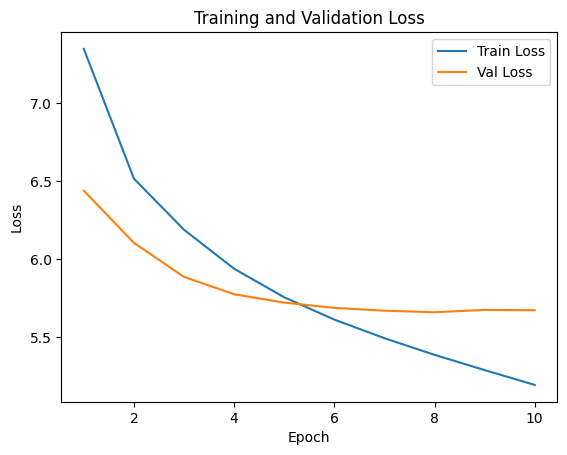

Model saved.


In [9]:
if __name__ == "__main__":
    main()

In [10]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Copy the model file to Google Drive
!cp transformer_lm_1.pt /content/drive/My\ Drive/

print("Model 'transformer_lm_1.pt' saved to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model 'transformer_lm_1.pt' saved to Google Drive.


In [ ]:
import torch
import torch.nn.functional as F
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
def inference(model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=10, temperature=0.6):
    """
    Loads the trained Transformer model, processes test.txt, generates text,
    and calculates perplexity.

    Args:
        model_path (str): Path to the saved model.
        test_file (str): Path to test.txt.
        tokenizer (dict): Token-to-ID mapping.
        tokenizer_inv (dict): ID-to-token mapping.
        gen_tokens (int): Number of tokens to generate per sentence.
        temperature (float): Sampling temperature for text generation.

    Returns:
        List[str]: List of generated texts.
        float: Computed perplexity score.
    """
    # Load model
    model = TransformerLM(
      vocab_size=len(tokenizer),
      embed_dim=128,
      num_heads=4,
      ff_dim=256,
      num_layers=6,
      max_len=128  # Or same as during training
      ).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Read test.txt
    with open(test_file, "r", encoding="utf-8") as f:
        test_sentences = f.readlines()

    generated_texts = []
    total_loss = 0
    total_tokens = 0
    criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"], reduction="sum")

    for sentence in test_sentences:
        sentence = sentence.strip()
        if not sentence:
            continue  # Skip empty lines

        # Tokenize input sentence
        input_ids = [tokenizer.get(token, tokenizer["<UNK>"]) for token in sentence.split()]
        inp_t = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)

        # Generate text
        generated_tokens = generate_text(model, tokenizer, tokenizer_inv, context=sentence, gen_tokens=gen_tokens, temperature=temperature)
        generated_texts.append(generated_tokens)

         # Calculate loss for each token in the generated sequence
        for i in range(len(input_ids) - 1):  # Iterate over input tokens (except the last one)
            inp_t_single = torch.tensor(input_ids[:i + 1], dtype=torch.long).unsqueeze(0).to(DEVICE)
            target_token = input_ids[i + 1]  # Get the next (target) token
            target_t = torch.tensor([target_token], dtype=torch.long).to(DEVICE)

            with torch.no_grad():
                logits, _ = model(inp_t_single)
                loss = criterion(logits[0, -1, :].unsqueeze(0), target_t)  # Compare with target token
                total_loss += loss.item()
                total_tokens += 1

    # Calculate perplexity
    perplexity = torch.exp(torch.tensor(total_loss / total_tokens)) if total_tokens > 0 else float('inf')

    return generated_texts, perplexity.item(),test_sentences

# Example Usage
model_path = "/content/drive/My Drive/transformer_lm_1.pt"
test_file = "shakespear_dev.txt"

gen_tokens = 20  # Number of tokens to generate per sentence
temperature = 0.6  # Sampling temperature

# Load and preprocess data (to get tokenizer and tokenizer_inv)
train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()



# Call evaluate_test_file
generated_texts, ppl ,test_sentences= inference(
    model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=gen_tokens, temperature=temperature
)

# Save output.txt in current directory
output_path = "output.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for i, (orig_line, gen_text) in enumerate(zip(test_sentences, generated_texts)):
        f.write(f"Input [{i+1}]: {orig_line.strip()}\n")
        f.write(f"Generated [{i+1}]: {gen_text.strip()}\n")
        f.write("---\n")
    f.write(f"\nFinal Test Perplexity: {ppl:.4f}\n")

print(f"\n Output saved to: {output_path}")

# Print the generated text and perplexity
for i, text in enumerate(generated_texts):
    print(f"Generated [{i+1}]: {text}")
print(f"Test Perplexity: {ppl:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Output saved to: output.txt
Generated [1]: , if there be no remedy for it , but that you will needs buy and sell men and women like beasts , we shall have all the world drink brown and white bastard . ' the pleasure . ' the wiser best . ' the queen 's as they are for the king ,
Generated [2]: DUKE VINCENTIO : O heavens ! ' the devil ! ' the prince , For wondrous swords . ' the court ? ' the queen 's
Generated [3]: what stuff is here POMPEY : 'T was never merry world since , of two , the was put down , and the worser allowed by order of law a gown to keep him warm ; and with and too , to signify , that craft , being richer than innocency , stands for the . ' the father 's death ; and since I have a bowl of your own business . ' the sun
Generated [4]: ELBOW : Come your way , sir . ' the good father 's eyes of the Tower : he did not the other , The other 's s